# Import Data

# Invalid Prediction

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import math

In [3]:
# importing libraries
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout
from keras.layers import GRU, Bidirectional
from keras.optimizers import SGD
from sklearn import metrics
from sklearn.metrics import mean_squared_error

In [4]:
df = pd.read_csv("Ming1Jul67_total_order.csv")
df.head(5)
df['order_completed_at'] = pd.to_datetime(df['order_completed_at'])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   order_completed_at  548 non-null    datetime64[ns]
 1   unique_order_count  548 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 8.7 KB


In [8]:
print(df.head())
print(df.tail())

  order_completed_at  unique_order_count
0         2023-01-01                  15
1         2023-01-02                  32
2         2023-01-03                  89
3         2023-01-04                  73
4         2023-01-05                  67
    order_completed_at  unique_order_count
543         2024-06-27                 145
544         2024-06-28                 142
545         2024-06-29                 126
546         2024-06-30                 161
547         2024-07-01                 142


# Reshape data
### for deep learning

In [9]:
data = df.iloc[:,1:2] 
print(data.head())
print(data.shape)

   unique_order_count
0                  15
1                  32
2                  89
3                  73
4                  67
(548, 1)


In [10]:
# Selecting Open Price values
dataset = data.unique_order_count.values 
# Reshaping 1D to 2D array
dataset = np.reshape(dataset, (-1,1)) 
dataset.shape

(548, 1)

# Feature Scaling

In [37]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
# scaling dataset
dataset_scaled = scaler.fit_transform(dataset)

print(dataset_scaled[:5])

[[0.004363  ]
 [0.01919721]
 [0.06893543]
 [0.05497382]
 [0.04973822]]


In [13]:
X_dataset = []
y_dataset = []
for i in range(50, len(dataset_scaled)):
    X_dataset.append(dataset_scaled[i-50:i, 0])
    y_dataset.append(dataset_scaled[i, 0])
    if i <= 51:
        print(X_dataset)
        print(y_dataset)
        print()

[array([0.004363  , 0.01919721, 0.06893543, 0.05497382, 0.04973822,
       0.05671902, 0.03664921, 0.03403141, 0.02705061, 0.05846422,
       0.05322862, 0.05061082, 0.03926702, 0.03752182, 0.04624782,
       0.19982548, 0.2513089 , 0.20418848, 0.11518325, 0.01570681,
       0.        , 0.0017452 , 0.01745201, 0.02792321, 0.04712042,
       0.02356021, 0.02530541, 0.04886562, 0.02356021, 0.02705061,
       0.06457243, 0.03403141, 0.52268761, 0.02705061, 0.02966841,
       0.02792321, 0.05148342, 0.04624782, 0.02443281, 0.03752182,
       0.02443281, 0.03141361, 0.11518325, 0.07940663, 0.10122164,
       0.02879581, 0.06893543, 0.03577661, 0.01832461, 0.008726  ])]
[0.02617801047120419]

[array([0.004363  , 0.01919721, 0.06893543, 0.05497382, 0.04973822,
       0.05671902, 0.03664921, 0.03403141, 0.02705061, 0.05846422,
       0.05322862, 0.05061082, 0.03926702, 0.03752182, 0.04624782,
       0.19982548, 0.2513089 , 0.20418848, 0.11518325, 0.01570681,
       0.        , 0.0017452 , 0.01

In [14]:
# The data is converted to Numpy array
X_dataset, y_dataset = np.array(X_dataset), np.array(y_dataset)
 
#Reshaping
X_dataset = np.reshape(X_dataset, (X_dataset.shape[0], X_dataset.shape[1],1))
y_dataset = np.reshape(y_dataset, (y_dataset.shape[0],1))
print("X_train :",X_dataset.shape,"y_train :",y_dataset.shape)

X_train : (498, 50, 1) y_train : (498, 1)


In [16]:
from tensorflow import keras

In [22]:
model = keras.models.load_model('../notenook/train_regressorLSTM_1Jul67.keras')

In [23]:
# fitting the model
history = model.fit(X_dataset, y_dataset, epochs = 20, batch_size = 2)
model.summary()

Epoch 1/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.0032 - loss: 0.0078
Epoch 2/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 8.0498e-04 - loss: 0.0076
Epoch 3/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.0029 - loss: 0.0089
Epoch 4/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.0056 - loss: 0.0071
Epoch 5/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.0080 - loss: 0.0085
Epoch 6/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.0027 - loss: 0.0089
Epoch 7/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 4.0581e-04 - loss: 0.0060
Epoch 8/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.0016 - loss: 0.0056
Epoch 9/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.0018 - loss: 0.0083
Epoch 10/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.0035 - loss: 0.0058
Epoch 11/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.0010 - loss: 0.0066    
Epoch 12/20
249/249 ━━━━━━━━━

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95,705 (373.85 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 63,804 (249.24 KB)

dict_keys(['accuracy', 'loss'])


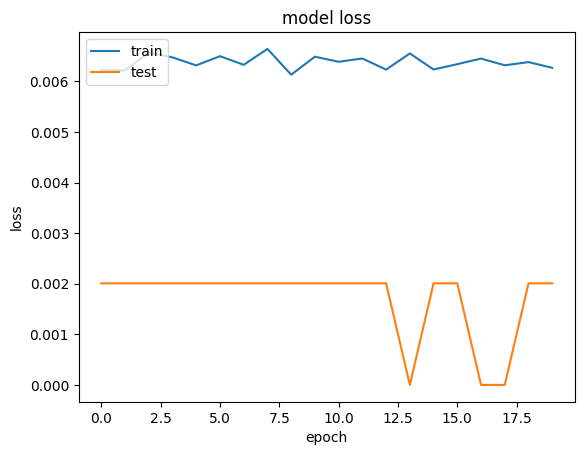

In [26]:
#list all data in history
print(history.history.keys())
#summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [28]:
y_LSTM = model.predict(X_dataset)
y_LSTM_O = scaler.inverse_transform(y_LSTM)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [27]:
print(data.index)

RangeIndex(start=0, stop=548, step=1)


In [29]:
print(y_LSTM_O)

[[ 93.76824 ]
 [105.73664 ]
 [124.549614]
 [153.13788 ]
 [150.17162 ]
 [119.984085]
 [160.15005 ]
 [155.18442 ]
 [152.6961  ]
 [169.69041 ]
 [118.74464 ]
 [109.50037 ]
 [356.391   ]
 [126.3314  ]
 [105.33023 ]
 [131.74513 ]
 [135.43509 ]
 [124.61409 ]
 [131.3434  ]
 [131.11946 ]
 [127.11435 ]
 [114.88686 ]
 [124.19339 ]
 [124.593056]
 [155.84053 ]
 [141.95723 ]
 [146.73872 ]
 [134.06606 ]
 [144.32704 ]
 [167.2832  ]
 [160.13205 ]
 [151.5481  ]
 [150.4465  ]
 [137.20477 ]
 [123.23771 ]
 [128.94983 ]
 [134.47937 ]
 [141.68951 ]
 [146.64296 ]
 [144.5088  ]
 [145.72426 ]
 [116.96824 ]
 [109.45519 ]
 [133.5571  ]
 [240.12207 ]
 [135.8848  ]
 [126.79588 ]
 [113.374504]
 [132.42609 ]
 [124.29611 ]
 [125.12639 ]
 [107.600426]
 [ 91.41486 ]
 [ 89.85191 ]
 [ 89.35498 ]
 [ 92.471954]
 [ 92.585106]
 [115.63109 ]
 [139.74261 ]
 [122.75072 ]
 [119.1567  ]
 [106.34539 ]
 [111.04559 ]
 [104.60429 ]
 [108.3502  ]
 [111.89143 ]
 [116.63226 ]
 [111.38784 ]
 [107.7757  ]
 [ 99.01948 ]
 [113.38995 ]
 [114.

Text(0.5, 1.0, 'Basic LSTM')

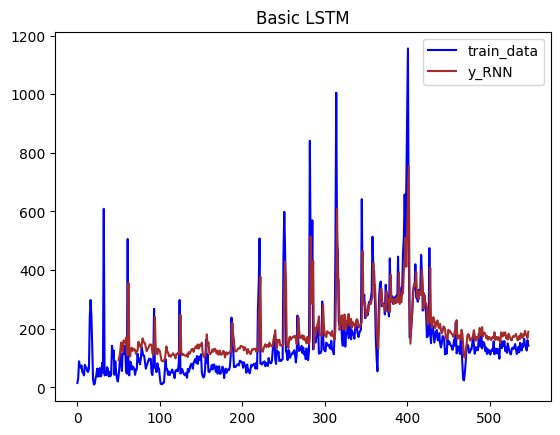

In [34]:
#Plot for RNN predictions
plt.plot(data.index, data.unique_order_count, label = "train_data", color = "b")
plt.plot(data.index[50:],y_LSTM_O, label = "y_RNN", color = "brown")
plt.legend()
plt.title("Basic LSTM")

# Fail Forecast

In [38]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# สมมติว่าคุณมีโมเดล LSTM ที่ผ่านการเทรนแล้วชื่อ 'model'
# และข้อมูลของคุณอยู่ในตัวแปรชื่อ 'data'

# ขั้นตอนที่ 1: เตรียมข้อมูลอินพุต
scaled_data = dataset_scaled 

# กำหนดจำนวนวันที่ใช้เป็นอินพุต และจำนวนวันที่ต้องการทำนาย
n_steps = 50  # ใช้ข้อมูล 50 วันล่าสุดเป็นอินพุต
n_future = 7  # ทำนาย 7 วันถัดไป (1 สัปดาห์)

# เตรียมข้อมูล n_steps วันล่าสุดเป็นอินพุต
X_forecast = scaled_data[-n_steps:].reshape((1, n_steps, 1))

# ขั้นตอนที่ 2: ทำนายทีละวันเป็นเวลา 1 สัปดาห์
predictions = []

for _ in range(n_future):
    # ทำนายค่าสำหรับวันถัดไป
    next_day_scaled = model.predict(X_forecast)
    
    # แปลงค่าที่ทำนายกลับเป็นสเกลเดิม
    next_day = scaler.inverse_transform(next_day_scaled)[0, 0]
    
    # เพิ่มค่าที่ทำนายได้เข้าไปในลิสต์
    predictions.append(next_day)
    
    # ปรับปรุง X_forecast สำหรับการทำนายวันถัดไป
    X_forecast = np.roll(X_forecast, -1, axis=1)
    X_forecast[0, -1, 0] = next_day_scaled[0, 0]

# ตอนนี้ 'predictions' มีค่าที่ทำนายสำหรับ 7 วันถัดไป
print("ค่าที่ทำนายสำหรับ 7 วันถัดไป:")
for i, pred in enumerate(predictions, 1):
    print(f"วันที่ {i}: {pred}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
ค่าที่ทำนายสำหรับ 7 วันถัดไป:
วันที่ 1: 179.6105194091797
วันที่ 2: 202.557373046875
วันที่ 3: 217.3423614501953
วันที่ 4: 227.0702667236328
วันที่ 5: 233.0236358642578
วันที่ 6: 236.6011505126953
วันที่ 7: 238.93968200683594


# Output Chunk Forecasting

In [ ]:
#https://stackoverflow.com/questions/69906416/forecast-future-values-with-lstm-in-python

In [39]:
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

In [64]:
df = pd.read_csv("Ming1Jul67_total_order.csv")
df['order_completed_at'] = pd.to_datetime(df['order_completed_at'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   order_completed_at  548 non-null    datetime64[ns]
 1   unique_order_count  548 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 8.7 KB


In [65]:
df.index = df["order_completed_at"]
df = df.drop(["order_completed_at"], axis=1)

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 548 entries, 2023-01-01 to 2024-07-01
Data columns (total 1 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   unique_order_count  548 non-null    int64
dtypes: int64(1)
memory usage: 8.6 KB


In [67]:
df.head(5)

,unique_order_count
order_completed_at,
2023-01-01,15
2023-01-02,32
2023-01-03,89
2023-01-04,73
2023-01-05,67


In [69]:
# download the data
y = df['unique_order_count'].fillna(method='ffill')
y = y.values.reshape(-1, 1)

# scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(y)
y = scaler.transform(y)

# generate the input and output sequences
n_lookback = 50  # length of input sequences (lookback period)
n_forecast = 7  # length of output sequences (forecast period)

X = []
Y = []

for i in range(n_lookback, len(y) - n_forecast + 1):
    X.append(y[i - n_lookback: i])
    Y.append(y[i: i + n_forecast])

X = np.array(X)
Y = np.array(Y)

C:\Users\User\AppData\Local\Temp\ipykernel_11952\204435806.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y = df['unique_order_count'].fillna(method='ffill')


In [70]:
# fit the model
model = Sequential()
model.add(LSTM(50, return_sequences = True,input_shape = (n_lookback,1)))
model.add(LSTM(50, return_sequences = False))
model.add(Dense(25))
model.add(Dense(n_forecast))

model.compile(loss='mean_squared_error', optimizer='adam',metrics = ["accuracy"])
model.fit(X, Y, epochs=100, batch_size=32, verbose=1)

Epoch 1/100


d:\Ming\ProgramLang_And_IDE\Python67\pythonVenv\MachineLearning\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.0000e+00 - loss: 0.0255
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 2.9461e-05 - loss: 0.0102
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 5.6523e-05 - loss: 0.0092
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.3888e-05 - loss: 0.0090
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.3358e-05 - loss: 0.0089
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 2.0147e-04 - loss: 0.0088
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 2.1074e-04 - loss: 0.0087
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 2.3666e-04 - loss: 0.0086
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 2.1603e-04 - loss: 0.0086
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 2.2311e-04 - loss: 0.0086
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 2.2665e-04 - loss: 0.0086
Epoch 12/100
16/16 ━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


C:\Users\User\AppData\Local\Temp\ipykernel_11952\3570624506.py:13: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]


<Axes: title={'center': 'Total Order'}, xlabel='Date'>

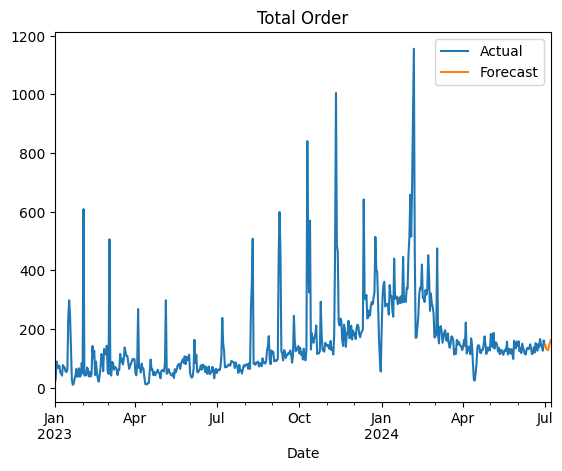

In [71]:
# generate the forecasts
X_ = y[- n_lookback:]  # last available input sequence
X_ = X_.reshape(1, n_lookback, 1)

Y_ = model.predict(X_).reshape(-1, 1)
Y_ = scaler.inverse_transform(Y_)

# organize the results in a data frame
df_past = df[['unique_order_count']].reset_index()
df_past.rename(columns={'order_completed_at': 'Date', 'unique_order_count': 'Actual'}, inplace=True)
df_past['Date'] = pd.to_datetime(df_past['Date'])
df_past['Forecast'] = np.nan
df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]

df_future = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_future['Date'] = pd.date_range(start=df_past['Date'].iloc[-1] + pd.Timedelta(days=1), periods=n_forecast)
df_future['Forecast'] = Y_.flatten()
df_future['Actual'] = np.nan

results = pd.concat([df_past, df_future]).set_index('Date')

# plot the results
results.plot(title='Total Order')

In [72]:
print(df_future)

        Date  Actual    Forecast
0 2024-07-02     NaN  144.583679
1 2024-07-03     NaN  131.461639
2 2024-07-04     NaN  129.343185
3 2024-07-05     NaN  127.648048
4 2024-07-06     NaN  143.419510
5 2024-07-07     NaN  153.690231
6 2024-07-08     NaN  161.365341


# Valid Prediction

In [113]:
#Initialising the model
model = Sequential()
 
#Adding LSTM layers
model.add(LSTM(50, return_sequences = True, input_shape = (50,1)))
model.add(LSTM(50, return_sequences = False))
model.add(Dense(25))
#Adding the output layer
model.add(Dense(1))
 
#Compiling the model
model.compile(optimizer = 'adam',
                      loss = 'mean_squared_error',
                      metrics = ["accuracy"])

d:\Ming\ProgramLang_And_IDE\Python67\pythonVenv\MachineLearning\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [59]:
model = keras.models.load_model('train_regressorLSTM_1Jul67.keras')

In [60]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [61]:
#load dataset
df = pd.read_csv("Ming2Jul67_total_order.csv")
df.head(5)
df['order_completed_at'] = pd.to_datetime(df['order_completed_at'])

# # load model 
# model = keras.models.load_model('../notenook/train_regressorLSTM_1Jul67.keras')

#preprocessing

data = df.iloc[:,1:2] 
print(data.head())
print(data.shape)

# Selecting Open Price values
dataset = data.unique_order_count.values 
# Reshaping 1D to 2D array
dataset = np.reshape(dataset, (-1,1)) 
dataset.shape

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
# scaling dataset
dataset_scaled = scaler.fit_transform(dataset)

X_dataset = []
y_dataset = []
for i in range(50, len(dataset_scaled)):
    X_dataset.append(dataset_scaled[i-50:i, 0])
    y_dataset.append(dataset_scaled[i, 0])
    if i <= 51:
        print(X_dataset)
        print(y_dataset)
        print()

# The data is converted to Numpy array
X_dataset, y_dataset = np.array(X_dataset), np.array(y_dataset)
 
#Reshaping
X_dataset = np.reshape(X_dataset, (X_dataset.shape[0], X_dataset.shape[1],1))
y_dataset = np.reshape(y_dataset, (y_dataset.shape[0],1))
print("X_train :",X_dataset.shape,"y_train :",y_dataset.shape)


# fit model with lasted data
filepath='weights_check/my_best_model.epoch{epoch:02d}-loss{loss:.2f}.keras'
checkpoint = ModelCheckpoint(filepath=filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

history = model.fit(X_dataset, y_dataset, epochs = 100, batch_size = 1, callbacks=callbacks_list)

   unique_order_count
0                  15
1                  32
2                  89
3                  73
4                  67
(549, 1)
[array([0.004363  , 0.01919721, 0.06893543, 0.05497382, 0.04973822,
       0.05671902, 0.03664921, 0.03403141, 0.02705061, 0.05846422,
       0.05322862, 0.05061082, 0.03926702, 0.03752182, 0.04624782,
       0.19982548, 0.2513089 , 0.20418848, 0.11518325, 0.01570681,
       0.        , 0.0017452 , 0.01745201, 0.02792321, 0.04712042,
       0.02356021, 0.02530541, 0.04886562, 0.02356021, 0.02705061,
       0.06457243, 0.03403141, 0.52268761, 0.02705061, 0.02966841,
       0.02792321, 0.05148342, 0.04624782, 0.02443281, 0.03752182,
       0.02443281, 0.03141361, 0.11518325, 0.07940663, 0.10122164,
       0.02879581, 0.06893543, 0.03577661, 0.01832461, 0.008726  ])]
[0.02617801047120419]

[array([0.004363  , 0.01919721, 0.06893543, 0.05497382, 0.04973822,
       0.05671902, 0.03664921, 0.03403141, 0.02705061, 0.05846422,
       0.05322862, 0.0506108

dict_keys(['accuracy', 'loss'])


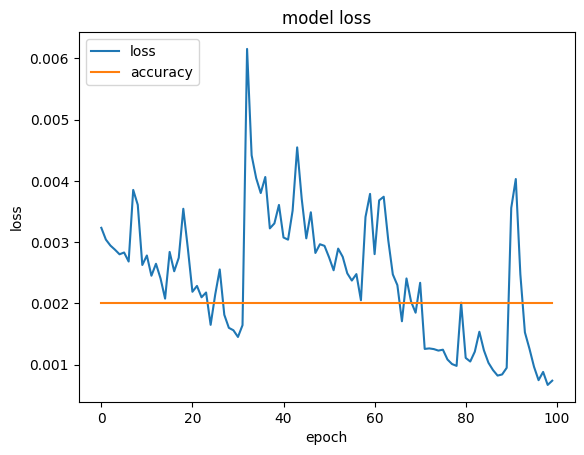

In [62]:
#list all data in history
print(history.history.keys())
#summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'accuracy'], loc='upper left')
plt.show()

### save best model

In [43]:
model = keras.models.load_model("weights_check\my_best_model.epoch99-loss0.00.keras")
model = model.save('train_regressorLSTM_1Jul67.keras')

In [63]:
model = keras.models.load_model('best_check/my_best_model.epoch99-loss0.00.keras')

### Future Prediction

In [64]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# สมมติว่าคุณมีโมเดล LSTM ที่ผ่านการเทรนแล้วชื่อ 'model'

# และข้อมูลของคุณอยู่ในตัวแปรชื่อ 'data'
# Selecting Open Price values

df = pd.read_csv("Ming2Jul67_total_order.csv")
df['order_completed_at'] = pd.to_datetime(df['order_completed_at'])
data = df
dataset = data.unique_order_count.values 
# Reshaping 1D to 2D array
dataset = np.reshape(dataset, (-1,1)) 

# ขั้นตอนที่ 1: เตรียมข้อมูลอินพุต
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# กำหนดจำนวนวันที่ใช้เป็นอินพุต และจำนวนวันที่ต้องการทำนาย
n_steps = 50  # ใช้ข้อมูล 50 วันล่าสุดเป็นอินพุต
n_future = 7  # ทำนาย 7 วันถัดไป (1 สัปดาห์)

# เตรียมข้อมูล n_steps วันล่าสุดเป็นอินพุต
last_steps = scaled_data[-n_steps:]
X_forecast = last_steps.reshape((1, n_steps, 1))
print(f"init lasted 5 days {scaler.inverse_transform(X_forecast[0][-5:])}")

# ขั้นตอนที่ 2: ใช้โมเดลทำนาย
forecasted_scaled = []

for _ in range(n_future):
    # ทำนายค่าถัดไป
    next_pred = model.predict(X_forecast)
    
    # เพิ่มค่าที่ทำนายได้เข้าไปในลิสต์
    forecasted_scaled.append(next_pred[0, 0])
    
    # อัปเดต X_forecast สำหรับการทำนายครั้งถัดไป
    X_forecast = np.roll(X_forecast, -1, axis=1)
    print(f"shift {_} {scaler.inverse_transform(X_forecast[0][-5:])}")
    print(f"predict {_} = {scaler.inverse_transform(next_pred)}")
    X_forecast[0, -1, 0] = next_pred[0, 0]
    print(f"after roll {_} {scaler.inverse_transform(X_forecast[0][-5:])}")

# ขั้นตอนที่ 3: ประมวลผลการทำนาย
# แปลงค่าที่ทำนายกลับเป็นสเกลเดิม
forecasted = scaler.inverse_transform(np.array(forecasted_scaled).reshape(-1, 1))
unscaled = np.array(forecasted_scaled)
# ตอนนี้ 'forecasted' มีค่าที่ทำนายสำหรับ 7 วันถัดไป

init lasted 5 days [[142.]
 [126.]
 [161.]
 [142.]
 [158.]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
shift 0 [[126.]
 [161.]
 [142.]
 [158.]
 [128.]]
predict 0 = [[152.44032]]
after roll 0 [[126.        ]
 [161.        ]
 [142.        ]
 [158.        ]
 [152.44032389]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
shift 1 [[161.        ]
 [142.        ]
 [158.        ]
 [152.44032389]
 [116.        ]]
predict 1 = [[162.5381]]
after roll 1 [[161.        ]
 [142.        ]
 [158.        ]
 [152.44032389]
 [162.53810215]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
shift 2 [[142.        ]
 [158.        ]
 [152.44032389]
 [162.53810215]
 [112.        ]]
predict 2 = [[163.97168]]
after roll 2 [[142.        ]
 [158.        ]
 [152.44032389]
 [162.53810215]
 [163.97167662]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
shift 3 [[158.        ]
 [152.44032389]
 [162.53810215]
 [163.97167662]
 [126.        ]]
predict 3 = [[164.40431]]
after roll 3 [[158.        ]
 [152.44032389]
 [162.53810215]
 [163.97167662]
 [164.404

In [65]:
print(forecasted)

[[152.44032]
 [162.5381 ]
 [163.97168]
 [164.40431]
 [162.0268 ]
 [161.76352]
 [162.4134 ]]


In [66]:
print(forecasted[0])

[152.44032]


In [67]:
forecasted_df = pd.DataFrame(forecasted)
print(forecasted_df.head())
print(forecasted_df.info())


            0
0  152.440323
1  162.538101
2  163.971680
3  164.404312
4  162.026794
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       7 non-null      float32
dtypes: float32(1)
memory usage: 156.0 bytes
None


### forecast dataframe

In [68]:
import pandas as pd
import numpy as np

# สมมติว่า forecasted คือ array ของผลการทำนาย
latest_date = df['order_completed_at'].max()
next_date = latest_date + pd.Timedelta(days=1)
print(next_date)

#forecast # สร้าง DataFrame
start_date = next_date
date_range = pd.date_range(start=start_date, periods=len(forecasted))
print(date_range)
forecasted_df = pd.DataFrame(forecasted)

forecasted_df = pd.DataFrame({
    'date': date_range,
    'total_order': forecasted_df[0]
})

# แสดงผล
print(forecasted_df)
print("\nข้อมูลของ DataFrame:")
print(forecasted_df.info())

2024-07-03 00:00:00
DatetimeIndex(['2024-07-03', '2024-07-04', '2024-07-05', '2024-07-06',
               '2024-07-07', '2024-07-08', '2024-07-09'],
              dtype='datetime64[ns]', freq='D')
        date  total_order
0 2024-07-03   152.440323
1 2024-07-04   162.538101
2 2024-07-05   163.971680
3 2024-07-06   164.404312
4 2024-07-07   162.026794
5 2024-07-08   161.763519
6 2024-07-09   162.413406

ข้อมูลของ DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         7 non-null      datetime64[ns]
 1   total_order  7 non-null      float32       
dtypes: datetime64[ns](1), float32(1)
memory usage: 212.0 bytes
None


In [ ]:
# print(len((X_forecast)[0]))
# print(unscaled)